In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from models.Loader import load_model
from models.Wrappers import Transformer_wrapper, Reduced_transformer_wrapper, Reduced_io_transformer_wrapper, Reduced_o_DLinear_wrapper
from torch.autograd import Variable
from utils.shap_tools import ChronoSHAP
from cycler import cycler

# import argparse
import os
import torch
# import copy
# from exp.exp_main import Exp_Main
# import random
import numpy as np

import shap
import pickle

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


%matplotlib qt5 
# %matplotlib widget
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import pandas as pd 

data_path = "dataset/"
datasets = dict()

# data_files = os.listdir(data_path)
# data_files.remove("all_six_datasets.zip")
# print(len(data_files))

# for f in ["electricity.csv", "ETTh1.csv", "ETTh2.csv", "ETTm1.csv", "ETTm2.csv", "exchange_rate.csv", "national_illness.csv", "traffic.csv", "weather.csv"]:
for f in ["exchange_rate.csv"]:
    print(f.replace(".csv",""))        
    dataset = pd.read_csv(data_path+f)
#     display(dataset.describe())
    datasets[f.replace(".csv","")] = dataset

exchange_rate


date     object
0       float64
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
OT      float64
dtype: object


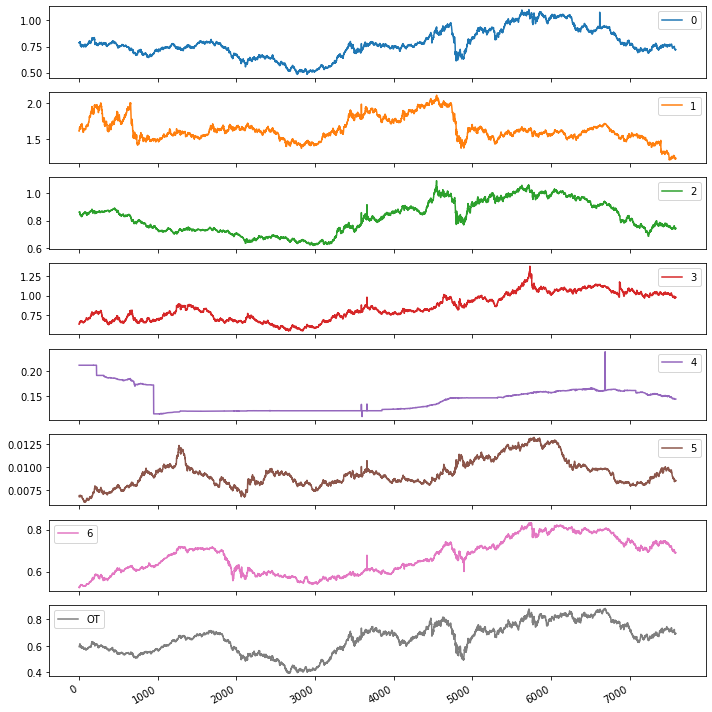

In [3]:
dataset_key = "exchange_rate"

dset = datasets[dataset_key]
print(dset.dtypes)

# %matplotlib inline 
datasets["exchange_rate"].plot(subplots=True, figsize=(10, 10))
plt.tight_layout()
plt.show()

# dset = datasets["exchange_rate"].loc[:, datasets["exchange_rate"].columns != 'date']

Arg use_gpu initial: False
Args in experiment:
Namespace(activation='gelu', batch_size=8, c_out=8, checkpoints='/checkpoints', d_ff=2048, d_layers=1, d_model=512, data='custom', data_path='exchange_rate.csv', dec_in=7, des='Exp', devices='0,1,2,3', distil=True, do_predict=False, dropout=0.05, e_layers=2, embed='timeF', embed_type=0, enc_in=8, factor=1, features='M', freq='h', gpu=0, individual=True, is_training=1, itr=1, label_len=48, learning_rate=0.0005, loss='mse', lradj='type1', model='DLinear', model_id='Exchange_96_96', moving_avg=25, n_heads=8, num_workers=0, output_attention=False, patience=5, pred_len=96, root_path='./dataset/', save_pred_values=False, seed=15349, seq_len=96, target='OT', test_flop=False, train_epochs=20, train_only=False, use_amp=False, use_gpu=False, use_multi_gpu=False)
Use CPU
checkpoints/Exchange_96_96_DLinear_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0_seed15349/checkpoint.pth
test 1422
mse:0.08157526701688766, mae:0.20666

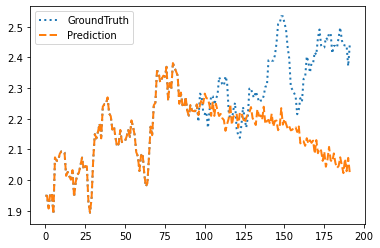

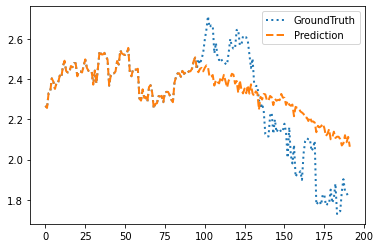

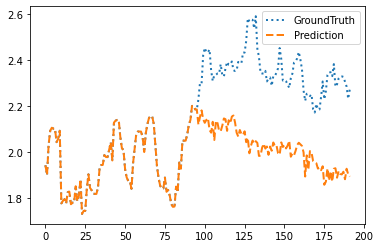

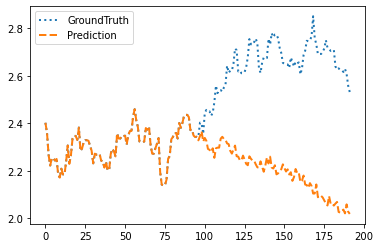

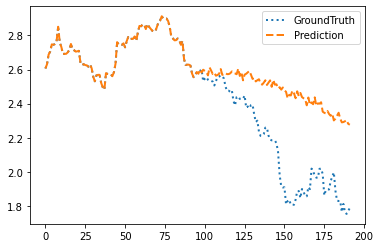

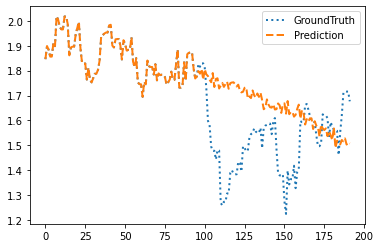

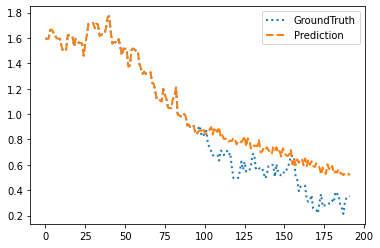

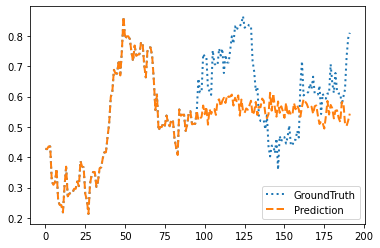

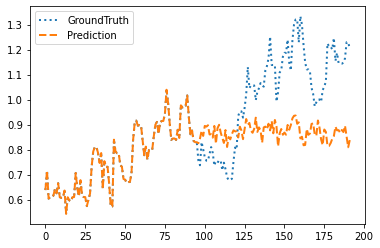

In [20]:
model_args = [
    "--is_training", "1", \
    "--seed", "15349", \
    "--num_workers", "0", \
    "--root_path", "./dataset/", \
    "--data_path", "exchange_rate.csv", \
    "--model_id", "Exchange_96_96", \
    "--model", "DLinear", \
    "--data", "custom", \
    "--features", "M", \
    "--seq_len", "96", \
    "--pred_len", "96", \
    "--enc_in", "8", \
    "--c_out", "8", \
    "--train_epochs", "20", \
    "--patience", "5", \
    "--des", "Exp", \
    "--itr", "1", \
    "--batch_size", "8", \
    "--learning_rate", "0.0005", \
    "--individual", \
    "--use_gpu", False, \
    "--checkpoints", "/checkpoints"]

exp, model, setting = load_model(model_args, load=True, return_copy=False)
# exp_no_train, model_no_train, setting_no_train = load_model(model_args, load=False, return_copy=False)

model.eval()
# model_no_train.eval()

# print("Testing trained model")
exp.test(setting)
# print("Testing untrained model")
# exp_no_train.test(setting_no_train)

# display(model)

In [53]:
exp.predict_simple(model_args)

pred 1


array([[[0.7219357 , 1.2474159 , 0.74609417, 0.97968084, 0.14363398,
         0.00854319, 0.68932444, 0.69370747],
        [0.7184244 , 1.2507461 , 0.7468318 , 0.97883046, 0.14367592,
         0.00854668, 0.690282  , 0.69328976],
        [0.7222624 , 1.2493685 , 0.7459529 , 0.9779591 , 0.14380665,
         0.00853182, 0.6915104 , 0.6922688 ],
        [0.723273  , 1.264042  , 0.7469824 , 0.9777061 , 0.14377944,
         0.00854648, 0.6911037 , 0.69590116],
        [0.7223368 , 1.2670438 , 0.74557006, 0.9789135 , 0.143859  ,
         0.00858901, 0.6909728 , 0.6936744 ],
        [0.72378874, 1.2656189 , 0.74644953, 0.9790221 , 0.14375927,
         0.00857699, 0.69134015, 0.6961119 ],
        [0.72178274, 1.2594941 , 0.74539715, 0.97800046, 0.14378513,
         0.00859768, 0.69038767, 0.6943953 ],
        [0.72093105, 1.2586298 , 0.7483194 , 0.9768548 , 0.14387897,
         0.00855768, 0.6916972 , 0.6946537 ],
        [0.7232458 , 1.2628068 , 0.74585783, 0.98014784, 0.14382975,
         0.

In [5]:
model

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=96, bias=True)
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): Linear(in_features=96, out_features=96, bias=True)
    (5): Linear(in_features=96, out_features=96, bias=True)
    (6): Linear(in_features=96, out_features=96, bias=True)
    (7): Linear(in_features=96, out_features=96, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=96, bias=True)
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): Linear(in_features=96, out_features=96, bias=True)
    

# Prepare inputs of the model

In [5]:
train_data, train_loader = exp._get_data("train")
for i, (batch_x_train_b, batch_y_train_b, batch_x_mark_train_b, batch_y_mark_train_b) in enumerate(train_loader):
#     print("i={}, Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(i, batch_x_train_b.shape, batch_x_mark_train_b.shape, batch_y_train_b.shape, batch_y_mark_train_b.shape))
    if (i==0):
        batch_x_train = torch.cat((batch_x_train_b,))
        batch_y_train = torch.cat((batch_y_train_b,))
        batch_x_mark_train = torch.cat((batch_x_mark_train_b,))
        batch_y_mark_train = torch.cat((batch_y_mark_train_b,))
    else:
        batch_x_train = torch.cat((batch_x_train, batch_x_train_b))
        batch_y_train = torch.cat((batch_y_train, batch_y_train_b))
        batch_x_mark_train = torch.cat((batch_x_mark_train, batch_x_mark_train_b))
        batch_y_mark_train = torch.cat((batch_y_mark_train, batch_y_mark_train_b))

batch_x_train = batch_x_train.float().to(next(model.parameters()).device)
batch_y_train = batch_y_train.float().to(next(model.parameters()).device)
batch_x_mark_train = batch_x_mark_train.float().to(next(model.parameters()).device)
batch_y_mark_train = batch_y_mark_train.float().to(next(model.parameters()).device)

# dec_inp_train = torch.zeros_like(batch_y_train[:, -train_data.pred_len:, :]).float()
# dec_inp_train = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

dec_inp_train = torch.zeros([batch_y_train.shape[0], train_data.pred_len, batch_y_train.shape[2]]).float().to(batch_y_train.device)
dec_inp_train = torch.cat([batch_y_train[:, :train_data.label_len, :], dec_inp_train], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x_train.shape, batch_x_mark_train.shape, dec_inp_train.shape, batch_y_mark_train.shape))

train 5120
Model input shapes: batch_x: torch.Size([5120, 96, 8]), batch_x_mark: torch.Size([5120, 96, 4]), dec_inp: torch.Size([5120, 144, 8]), batch_y_mark: torch.Size([5120, 144, 4])


In [6]:
pred_data, pred_loader = exp._get_data("pred")

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
    print("Shapes of batch_x: {}, batch_x_mark: {}, batch_y: {}, batch_y_mark: {}".format(batch_x.shape, batch_x_mark.shape, batch_y.shape, batch_y_mark.shape))
#     print("batch_x: ",batch_x[0,:,0])
#     print("batch_y: ",batch_y[0,:,0])
    print()

batch_x = batch_x.float().to(next(model.parameters()).device)
batch_y = batch_y.float().to(next(model.parameters()).device)
batch_x_mark = batch_x_mark.float().to(next(model.parameters()).device)
batch_y_mark = batch_y_mark.float().to(next(model.parameters()).device)

dec_inp = torch.zeros([batch_y.shape[0], pred_data.pred_len, batch_y.shape[2]]).float().to(batch_y.device)
dec_inp = torch.cat([batch_y[:, :pred_data.label_len, :], dec_inp], dim=1).float().to(next(model.parameters()).device)

print("Model input shapes: batch_x: {}, batch_x_mark: {}, dec_inp: {}, batch_y_mark: {}".format(batch_x.shape, batch_x_mark.shape, dec_inp.shape, batch_y_mark.shape))

pred 1
Shapes of batch_x: torch.Size([1, 96, 8]), batch_x_mark: torch.Size([1, 96, 4]), batch_y: torch.Size([1, 48, 8]), batch_y_mark: torch.Size([1, 144, 4])

Model input shapes: batch_x: torch.Size([1, 96, 8]), batch_x_mark: torch.Size([1, 96, 4]), dec_inp: torch.Size([1, 144, 8]), batch_y_mark: torch.Size([1, 144, 4])


# Reduced inputs and outputs model

In [7]:
reduced_o_wrapped_model = Reduced_o_DLinear_wrapper(exp.args).float().to(exp.device)
reduced_o_wrapped_model.load_state_dict(model.state_dict())
reduced_o_wrapped_model.eval()

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_o_wrapped_model.to(device)

Reduced_o_DLinear_wrapper(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=96, bias=True)
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): Linear(in_features=96, out_features=96, bias=True)
    (5): Linear(in_features=96, out_features=96, bias=True)
    (6): Linear(in_features=96, out_features=96, bias=True)
    (7): Linear(in_features=96, out_features=96, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=96, bias=True)
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): Linear(in_features=96, out_features

In [8]:
# Create list to identify feature and position in the input sequence
feature_list = []
for i in range(exp.args.c_out*exp.args.seq_len):
    feature_list.append("Feature {}, seq pos {} ".format(pred_data.cols[1:][i%exp.args.c_out], int(i/exp.args.c_out)))

In [9]:
print(exp.args.c_out)
print(exp.args.seq_len)
print(len(feature_list))

8
96
768


## DeepSHAP explainer (based on DeepLift)

In [11]:
# Get a subset of the train data
batch_x_train_sub = batch_x_train[::4,:,:]

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_o_wrapped_model.to(device)

# Flatten X to be fed to the model

reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

reduced_o_wrapped_model.set_pred_time_step(0)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_o_wrapped_model, reduced_new_input_train)
reduced_o_deep_shap_values = e.shap_values(reduced_new_input)

In [12]:
with open('Explanations/SHAP/dlinear_reduced_o_deep_shap_values_{}_backgr.pkl'.format(batch_x_train_sub.shape[0]), 'wb') as file:
    pickle.dump(reduced_o_deep_shap_values, file)

with open('Explanations/SHAP/dlinear_reduced_o_deep_shap_values_{}_backgr.pkl'.format(batch_x_train_sub.shape[0]), 'rb') as file:
    reduced_o_deep_shap_values = pickle.load(file)

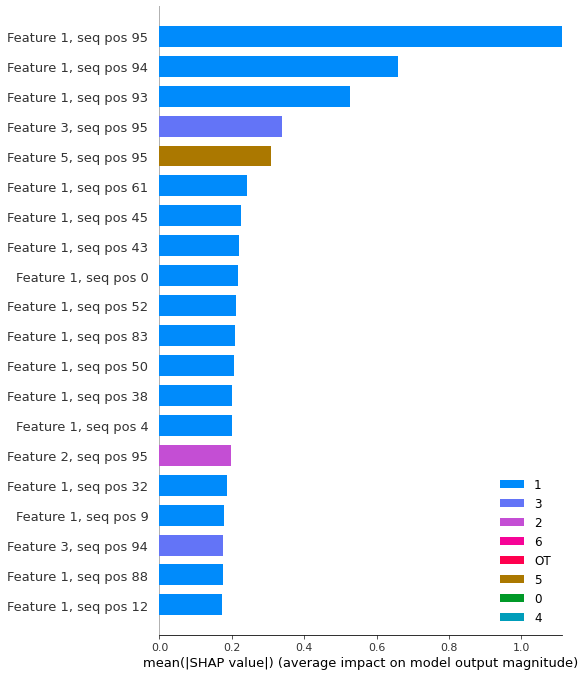

In [13]:
shap.summary_plot(reduced_o_deep_shap_values, reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:])


### Deep SHAP for full time horizon

In [10]:
num_train_samples = 50

# Get a subset of the train data
batch_x_train_sub = batch_x_train[::round(batch_x_train.shape[0]/num_train_samples+0.5),:,:]

# Set common device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
exp.device = device
reduced_o_wrapped_model.to(device)

# Flatten X to be fed to the model

reduced_new_input = batch_x.flatten(start_dim=1).to(device)
reduced_new_input_train = batch_x_train_sub.flatten(start_dim=1).to(device)

torch.set_grad_enabled(True)

e = shap.DeepExplainer(reduced_o_wrapped_model, reduced_new_input_train)

# Each explained prediction horizon has to be analyzed individually to make it work with SHAP, so we store them in a list
reduced_deep_shap_values = []

# for pred_hor in range(reduced_o_wrapped_model.pred_len):
#     reduced_o_wrapped_model.set_pred_time_step(pred_hor)
#     print("Analyzing time step {}".format(reduced_o_wrapped_model.get_pred_time_step()))
#     reduced_deep_shap_values.append(e.shap_values(reduced_new_input))

In [11]:
# with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'wb') as file:
#     pickle.dump(reduced_deep_shap_values, file)

with open("Explanations/SHAP/shap_values_{}_in_{}_out_{}_{}_bg_{}.pkl".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples), 'rb') as file:
    reduced_deep_shap_values = pickle.load(file)

time step 0


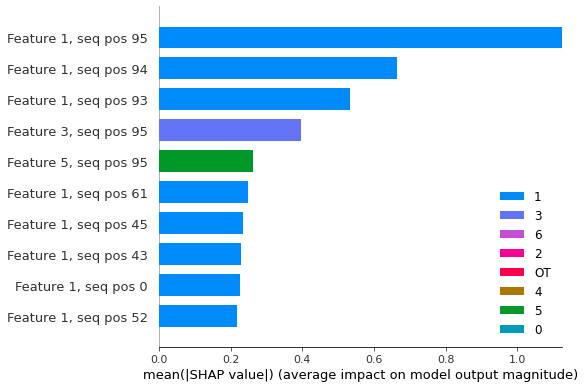

time step 48


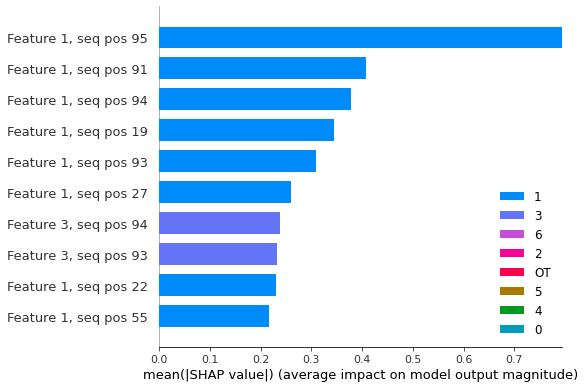

time step 94


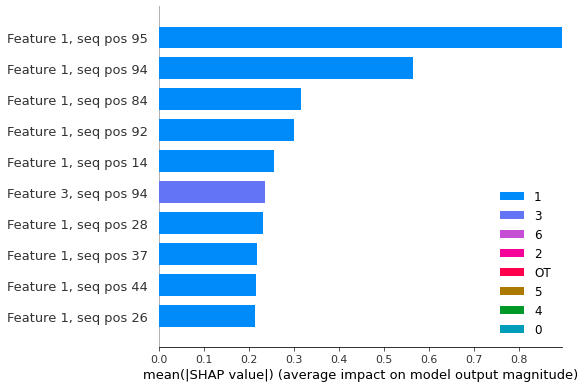

time step 95


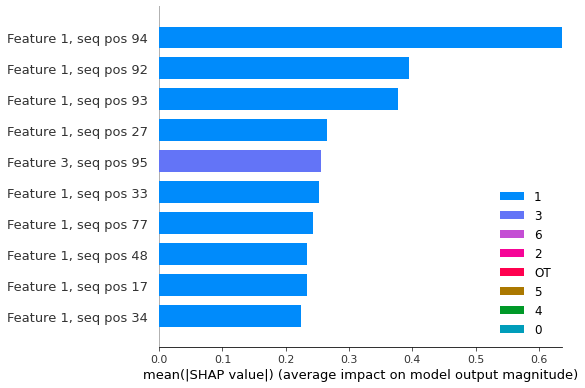

In [12]:
%matplotlib inline

for ind in [0, 48, 94, 95]:
    print("time step {}".format(ind))
    shap.summary_plot(reduced_deep_shap_values[ind], reduced_new_input, feature_names=feature_list, class_names=pred_data.cols[1:][:], max_display=10)

### Feature attribution scores evolution over time

We look at the evolution of the attribution scores
considering all time steps from input and output sequences. To
be able to display the overall evolution of the input features’
impact, we look separately into specific output features of the
model, gaining more general information about how the impact
of the features from different time steps of the input varies de-
pending on the prediction horizon.

Input/output mode
accum_signals.shape (96, 96)


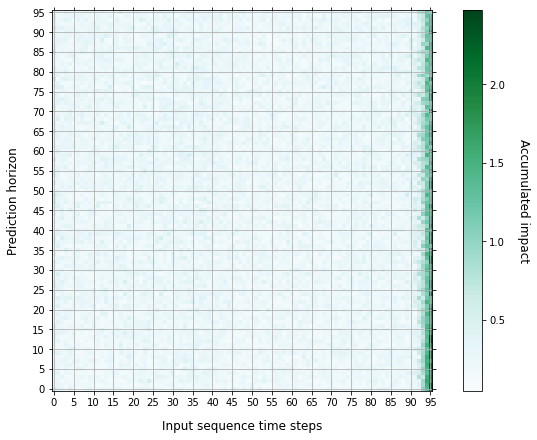

In [13]:
%matplotlib inline 
# %matplotlib qt5

custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

pred_hor = 0
out_feat = 0
mode = 1
path = "figures"
fig_name = "\\shap_overview_{}_in_{}_out_{}_{}_bg_{}.pdf".format(dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)

figsize = (11,7)


ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, grid=1, save=0, path=path+fig_name, figsize=figsize)




Output mode


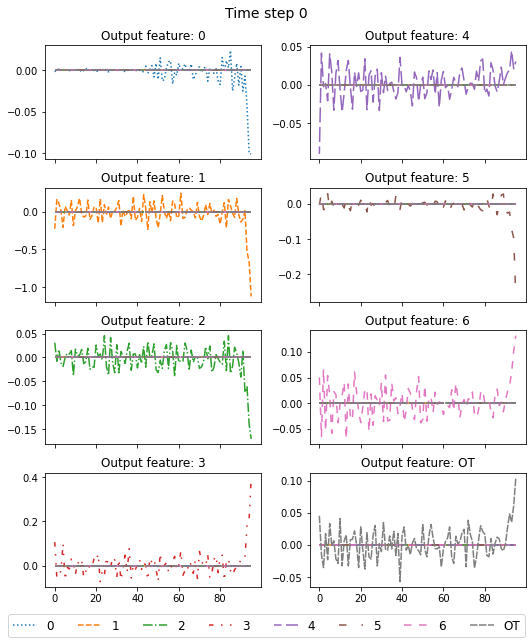

Output mode


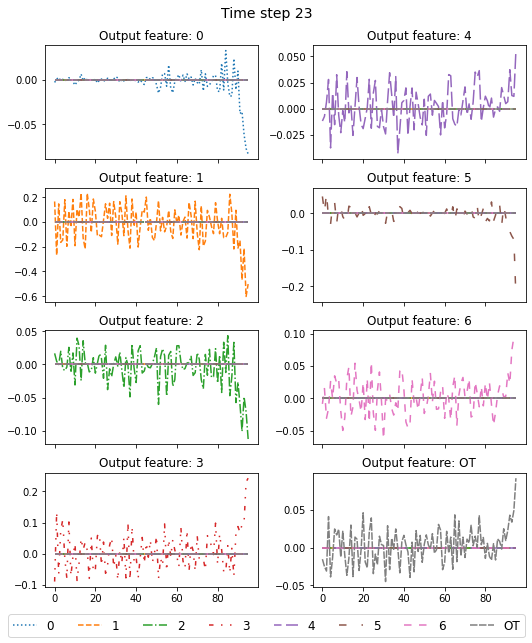

Output mode


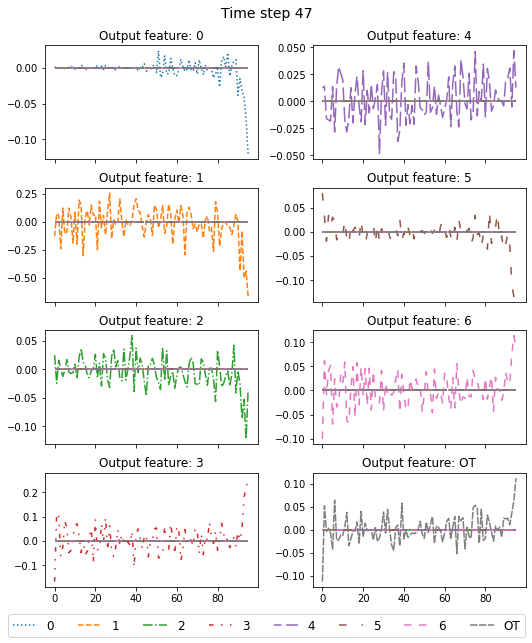

Output mode


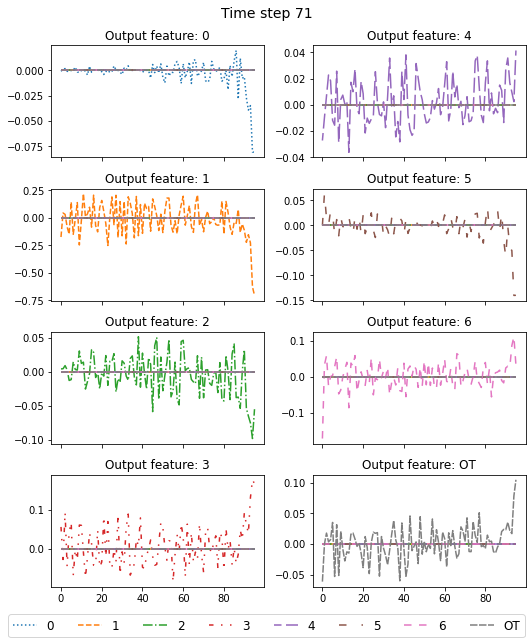

Output mode


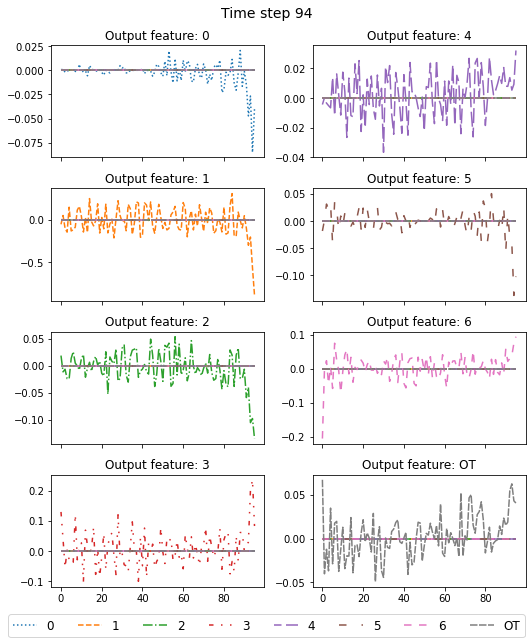

Output mode


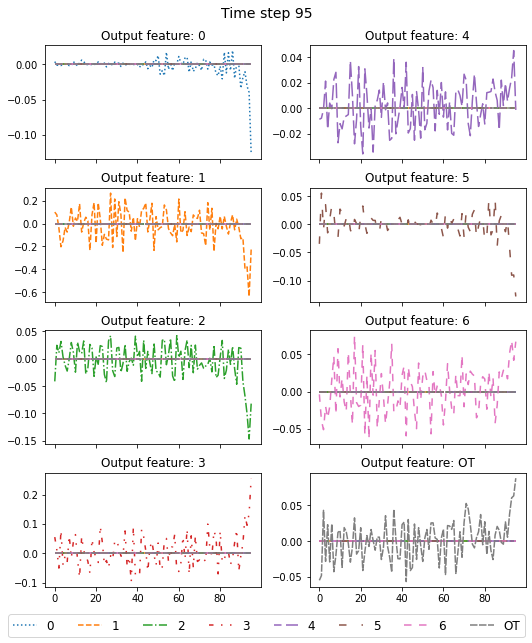

In [14]:
# %matplotlib widget
# matplotlib.use('Qt5Agg')
%matplotlib inline

custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:8]) + 
                 cycler(linestyle=['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 
                                   (5, (10, 3)), (0, (5, 10)), (0, (5, 5)), (0, (5, 1))]))
plt.rc('axes', prop_cycle=custom_cycler)

out_feat = 0
mode = 0
path = "figures"
figsize=(7.5, 9)

for pred_hor in [0, 23, 47, 71, 94, 95]:
# for pred_hor in [0]:
    fig_name = "\\shap_pred_hor_{}_{}_in_{}_out_{}_{}_bg_{}.pdf".format(pred_hor, dataset_key, exp.args.seq_len, exp.args.pred_len, exp.args.model, num_train_samples)
    ChronoSHAP(reduced_deep_shap_values, exp.args.seq_len, 
                       exp.args.c_out, pred_data.cols[1:], mode, pred_hor, out_feat, custom_cycler, grid=0, save=1, path=path+fig_name, figsize=figsize)


# The DLinear model seems to be purely autoregressive
## Check autoregressiveness ;D

### Both original model and wrapped model forecast the same


In [15]:
batch_x_train_sub.shape

torch.Size([50, 96, 8])

In [16]:
# Both original model and wrapped model forecast the same

for pred_hor in range(reduced_o_wrapped_model.pred_len):
    reduced_o_wrapped_model.set_pred_time_step(pred_hor)
    print("Predicting time step {}".format(reduced_o_wrapped_model.get_pred_time_step()))
    
    raw_preds_wrapper = reduced_o_wrapped_model(reduced_new_input)
    raw_preds_wrapper = pred_data.inverse_transform(raw_preds_wrapper.cpu().detach().numpy())
    
    raw_preds_model = model(batch_x)[:,pred_hor,:]
    raw_preds_model = pred_data.inverse_transform(raw_preds_model.cpu().detach().numpy())
    
    print((np.abs(raw_preds_wrapper-raw_preds_model)).sum())

Predicting time step 0
0.0
Predicting time step 1
0.0
Predicting time step 2
0.0
Predicting time step 3
0.0
Predicting time step 4
0.0
Predicting time step 5
0.0
Predicting time step 6
0.0
Predicting time step 7
0.0
Predicting time step 8
0.0
Predicting time step 9
0.0
Predicting time step 10
0.0
Predicting time step 11
0.0
Predicting time step 12
0.0
Predicting time step 13
0.0
Predicting time step 14
0.0
Predicting time step 15
0.0
Predicting time step 16
0.0
Predicting time step 17
0.0
Predicting time step 18
0.0
Predicting time step 19
0.0
Predicting time step 20
0.0
Predicting time step 21
0.0
Predicting time step 22
0.0
Predicting time step 23
0.0
Predicting time step 24
0.0
Predicting time step 25
0.0
Predicting time step 26
0.0
Predicting time step 27
0.0
Predicting time step 28
0.0
Predicting time step 29
0.0
Predicting time step 30
0.0
Predicting time step 31
0.0
Predicting time step 32
0.0
Predicting time step 33
0.0
Predicting time step 34
0.0
Predicting time step 35
0.0
Pr

### If we change all inputs features except one, the forecast for that feature does not change and all others do (indeed is autoregressive, not an error)

In [17]:
aux_batch_x = batch_x.clone().detach()

aux_batch_x[:,:,::2] = 1.5

(model(batch_x)[:,:,:]-model(aux_batch_x)[:,:,:]).sum(dim=0)

tensor([[-1.9057,  0.0000, -2.1505,  0.0000, -1.4178,  0.0000, -1.2604,  0.0000],
        [-1.9344,  0.0000, -2.1392,  0.0000, -1.4262,  0.0000, -1.2339,  0.0000],
        [-1.8959,  0.0000, -2.1534,  0.0000, -1.4142,  0.0000, -1.2293,  0.0000],
        [-1.8783,  0.0000, -2.1306,  0.0000, -1.4114,  0.0000, -1.2294,  0.0000],
        [-1.8824,  0.0000, -2.1498,  0.0000, -1.4137,  0.0000, -1.2135,  0.0000],
        [-1.8688,  0.0000, -2.1492,  0.0000, -1.4190,  0.0000, -1.2227,  0.0000],
        [-1.8837,  0.0000, -2.1635,  0.0000, -1.4025,  0.0000, -1.2365,  0.0000],
        [-1.8880,  0.0000, -2.1253,  0.0000, -1.4018,  0.0000, -1.2148,  0.0000],
        [-1.8638,  0.0000, -2.1302,  0.0000, -1.4160,  0.0000, -1.2007,  0.0000],
        [-1.8444,  0.0000, -2.1085,  0.0000, -1.4111,  0.0000, -1.2092,  0.0000],
        [-1.8425,  0.0000, -2.1133,  0.0000, -1.4057,  0.0000, -1.2277,  0.0000],
        [-1.8494,  0.0000, -2.0847,  0.0000, -1.4246,  0.0000, -1.2100,  0.0000],
        [-1.8494